## Загрузим нужные библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd

In [2]:
from src.util import df_to_gdf, add_region, encode_region, sort_cols

In [3]:
DATA_DIR = "./data/"

In [4]:
train_df = pd.read_csv(DATA_DIR + "train_dataset_train.csv").set_index("id")
test_df = pd.read_csv(DATA_DIR + "test_dataset_test.csv").set_index("id")

In [5]:
train_df = df_to_gdf(train_df)
test_df = df_to_gdf(test_df)

regions = gpd.read_file(DATA_DIR + "boundaries/admin_level_4.shp", encoding='cp1251')
regions = regions[["name_en", "geometry"]]

add_region(train_df, regions)
add_region(test_df, regions)

encode_region(train_df)
encode_region(test_df)

In [6]:
with_regions = (train_df.copy(), test_df.copy())

In [7]:
def add_centroid_coordinates(df: gpd.GeoDataFrame):
    df["center_x"] = df.geometry.centroid.x
    df["center_y"] = df.geometry.centroid.y

In [59]:
train_df, test_df = with_regions
with_regions = (train_df.copy(), test_df.copy())

In [71]:
add_centroid_coordinates(train_df)
add_centroid_coordinates(test_df)

## Выделим выборки

In [10]:
from src.util import get_ndvi_columns

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(get_ndvi_columns(train_df))

def add_min_max_positions(p: pd.DataFrame):
    p["min_at"] = le.transform(p.loc[:, get_ndvi_columns(p)].apply('idxmin', axis=1))
    p["max_at"] = le.transform(p.loc[:, get_ndvi_columns(p)].apply('idxmax', axis=1))
    p["mean_all"] = p[get_ndvi_columns(p)].mean(axis=1)
    p["median_all"] = p[get_ndvi_columns(p)].median(axis=1)
    p["max_all"] = p[get_ndvi_columns(p)].max(axis=1)
    p["std_all"] = p[get_ndvi_columns(p)].std(axis=1)

In [12]:
add_min_max_positions(train_df)
add_min_max_positions(test_df)
train_df.head()

,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,...,geometry,region,center_x,center_y,min_at,max_at,mean_all,median_all,max_all,std_all
id,,,,,,,,,,,,,,,,,,,,,
3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,0.484102,...,"POLYGON ((42.49107 51.41404, 42.49111 51.41400...",13,42.500831,51.413192,17,62,0.227016,0.115894,0.754859,0.247090
3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,0.519456,...,"POLYGON ((50.25545 56.60539, 50.25552 56.60523...",11,50.267528,56.605879,14,51,0.270592,0.174246,0.709037,0.255654
1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,0.000000,...,"POLYGON ((37.99699 53.83590, 38.00572 53.83333...",12,38.002610,53.836396,14,47,0.212570,0.120092,0.741171,0.244663
2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,0.510271,...,"POLYGON ((44.72154 55.93534, 44.72321 55.93180...",6,44.726868,55.935386,14,35,0.270053,0.157833,0.753284,0.249588
3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,0.000000,...,"POLYGON ((34.77830 52.90720, 34.77878 52.90710...",1,34.784405,52.907380,8,60,0.236884,0.124056,0.833694,0.264611


In [13]:
train_df = sort_cols(train_df)
test_df = sort_cols(test_df)

In [14]:
def add_diff(p):
    return p.join(p.loc[:, get_ndvi_columns(p)].diff(axis=1).rename(columns={col: col + "_diff" for col in p.columns}).iloc[:, 1:])

In [15]:
train_df = add_diff(train_df)
test_df = add_diff(test_df)

In [60]:
drop_cols = ["geometry", "area"]

In [72]:
X = train_df.drop(columns=drop_cols + ["crop"])
y = train_df.crop.ravel()

In [73]:
X.head()

,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,nd_mean_2021-05-16,nd_mean_2021-05-17,...,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,region,center_x,center_y
id,,,,,,,,,,,,,,,,,,,,,
3536,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,0.484102,0.201013,...,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,13,42.500831,51.413192
3739,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,0.519456,0.501486,...,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,11,50.267528,56.605879
1294,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,0.000000,0.561541,...,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,12,38.002610,53.836396
2859,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,0.510271,0.511552,...,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,6,44.726868,55.935386
3685,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,0.000000,0.403379,...,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,1,34.784405,52.907380


## Обучение модели

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
clf = RandomForestClassifier(random_state=42, n_estimators=500)

In [65]:
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

## Оценка точности

In [66]:
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

pred = clf.predict(X_val)
print(recall_score(y_val, pred, average="macro", zero_division=0))

0.9641955787516174


In [82]:
logging_config = {
    "version": 1,
    "disable_existing_loggers": True,
    "formatters": {
        "custom": {
            # More format options are available in the official
            # `documentation <https://docs.python.org/3/howto/logging-cookbook.html>`_
            "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
        }
    },
    # Any INFO level msg will be printed to the console
    "handlers": {
        "console": {
            "level": "INFO",
            "formatter": "custom",
            "class": "logging.StreamHandler",
            "stream": "ext://sys.stdout",
        },
    },
    "loggers": {
        "": {  # root logger
            "level": "DEBUG",
        },
        "Client-EnsembleBuilder": {
            "level": "DEBUG",
            "handlers": ["console"],
        },
    },
}

In [83]:
import autosklearn.classification
import autosklearn.metrics as metrics

auto_clf = autosklearn.classification.AutoSklearnClassifier(seed=42, metric=metrics.recall_macro, time_left_for_this_task=5 * 60,
                                                            scoring_functions=[metrics.recall_macro], memory_limit=8192, logging_config=logging_config)
auto_clf.fit(X_train, y_train)

2022-11-08 03:21:56,036 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-11-08 03:21:56,046 - Client-EnsembleBuilder - INFO - Ensemble Selection:
	Trajectory: 0: 0.04022
	Members: [0]
	Weights: [1.]
	Identifiers: (42, 2, 0.0)

2022-11-08 03:21:56,088 - Client-EnsembleBuilder - INFO - DummyFuture: ([{'Timestamp': Timestamp('2022-11-08 03:21:56.050787'), 'ensemble_optimization_score': 0.9597778339714572}], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.11.08-03.21.56 for iteration 0.
2022-11-08 03:22:27,192 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-11-08 03:22:27,197 - Client-EnsembleBuilder - INFO - All ensemble candidates the same, no update required
2022-11-08 03:22:27,221 - Client-EnsembleBuilder - INFO - DummyFuture: ([], 50)/SingleThreadedClient() Started Ensemble builder job at 2022.11.08-03.22.27 for iteration 1.
2022-11-08 03:22:58,321 - Client-EnsembleBuilder - INFO - Discarding 0/1 runs
2022-11-08 03:22:58,327 - Client-EnsembleBuilde

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      logging_config={'disable_existing_loggers': True,
                                      'formatters': {'custom': {'format': '%(asctime)s '
                                                                          '- '
                                                                          '%(name)s '
                                                                          '- '
                                                                          '%(levelname)s '
                                                                          '- '
                                                                          '%(message)s'}},
                                      'handlers': {'console': {'class': 'logging.StreamHandler',
                                                               'formatter': 'custom',
                                            

In [84]:
predictions = auto_clf.predict(X_val)
print(recall_score(y_val, predictions, average="macro", zero_division=0))

0.9618929044295584


In [85]:
print(auto_clf.sprint_statistics())

auto-sklearn results:
  Dataset name: 55ae542e-5efb-11ed-b716-085bd6c9dfb0
  Metric: recall_macro
  Best validation score: 0.960891
  Number of target algorithm runs: 25
  Number of successful target algorithm runs: 18
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 7
  Number of target algorithms that exceeded the memory limit: 0



In [40]:
auto_clf.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
44,1,0.02,gradient_boosting,0.026962,7.512281
92,2,0.02,gradient_boosting,0.027832,4.721009
39,3,0.90,sgd,0.053319,0.730243
19,4,0.02,random_forest,0.054871,14.279138
29,5,0.02,random_forest,0.069408,38.125387
50,6,0.02,mlp,0.070384,2.227716


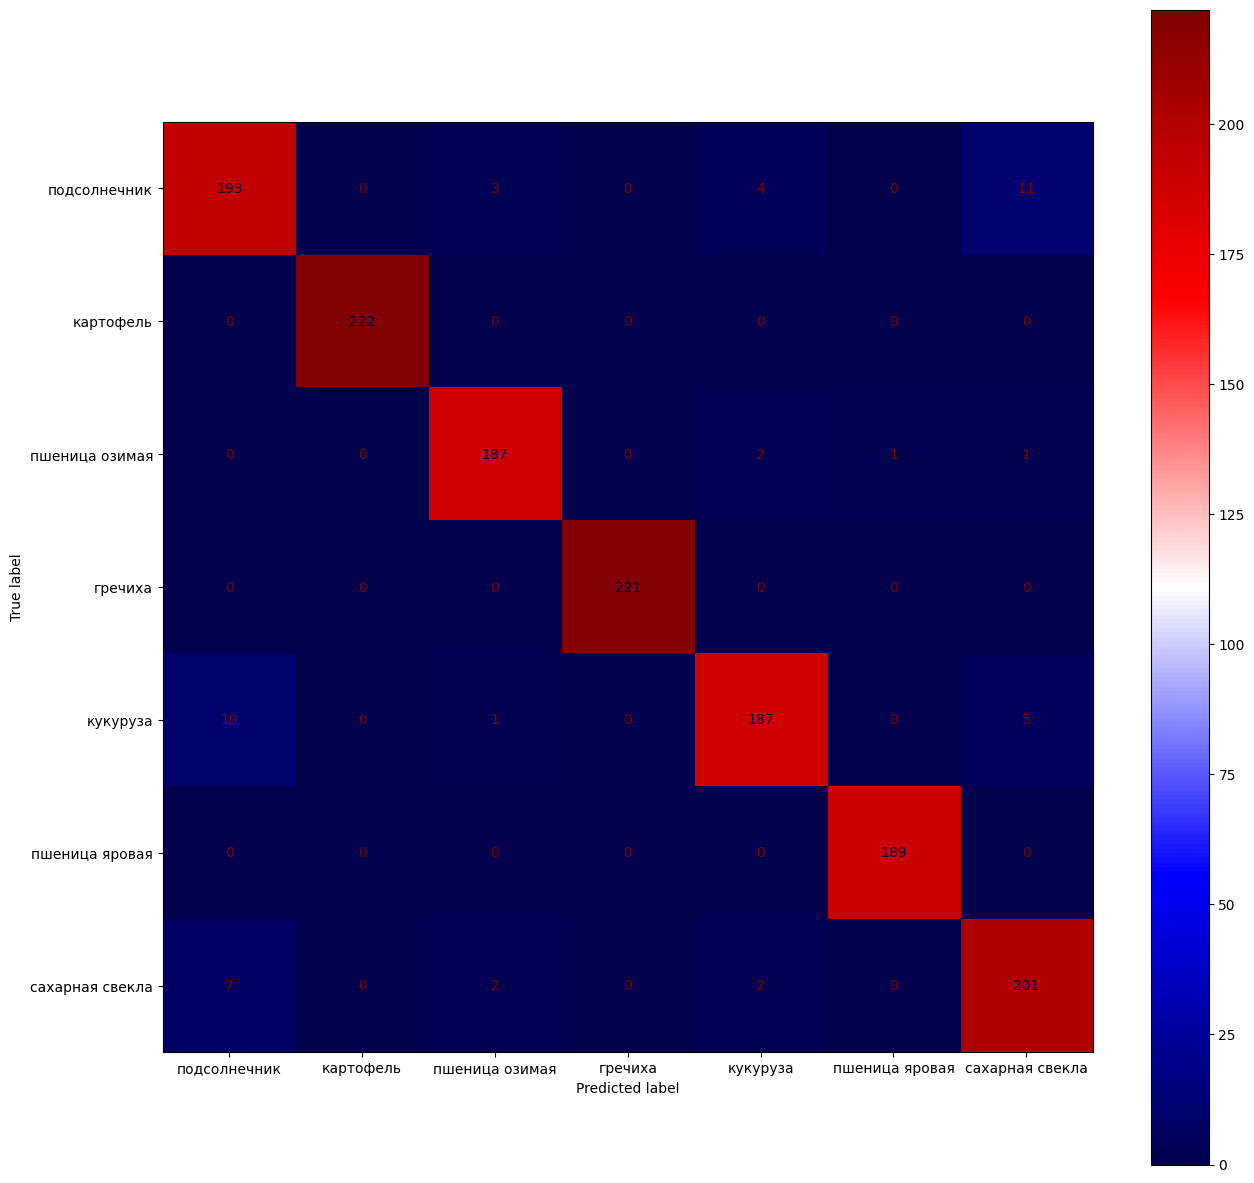

In [38]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)

cm = confusion_matrix(y_val, predictions)
ConfusionMatrixDisplay(cm, display_labels=['подсолнечник', 'картофель', 'пшеница озимая', 'гречиха', 'кукуруза', 'пшеница яровая', 'сахарная свекла']).plot(cmap='seismic')

In [52]:
X_test = test_df.drop(drop_cols, axis = 1)
y_test = auto_clf.predict(X_test)

In [53]:
submission_df = test_df.copy()
submission_df["crop"] = y_test
submission_df = submission_df[["crop"]]
submission_df.head()

,crop
id,
611,3
6417,2
3352,3
4224,1
3102,6


In [54]:
submission_df.to_csv(DATA_DIR + "submission.csv")

Text(0.5, 1.0, 'Feature Importance')

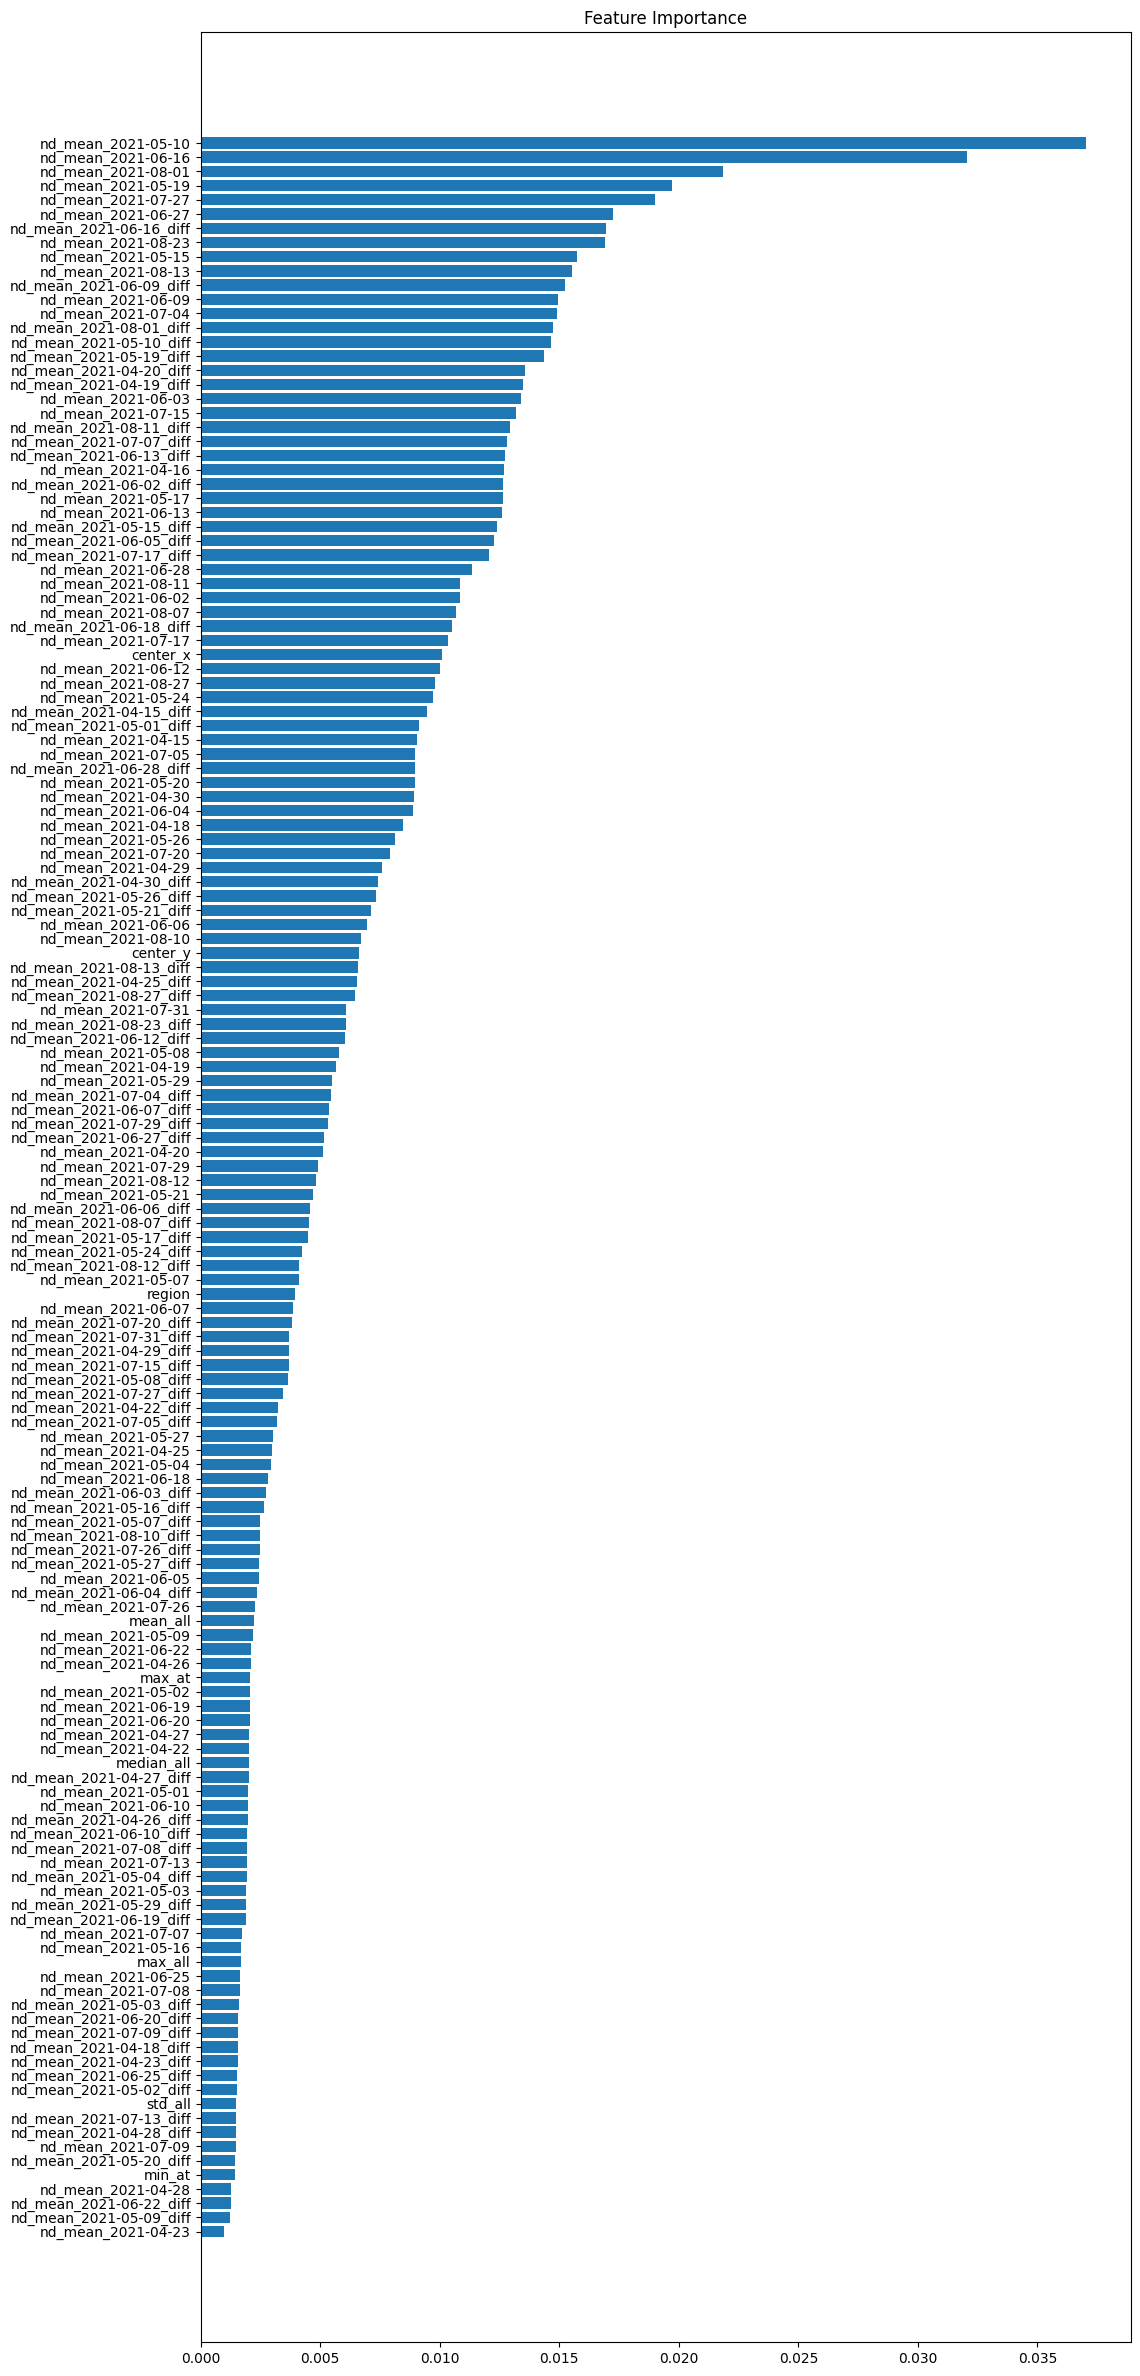

In [433]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')